In [1]:
import os
import pypsa 
import matplotlib.pyplot as plt
plt.style.use("bmh")
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns  ###
import cartopy.crs as ccrs
sns.set(style='darkgrid') ### seaborn gives a nice design

In [2]:
cd /home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_script_github-only-h2-all-assets_no_hydro_solver_accuracy2/scripts

/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_script_github-only-h2-all-assets_no_hydro_solver_accuracy2/scripts


In [3]:
from _helpers import *
from make_summary import assign_carriers
from plot_summary import plot_costs

## Upload network

In [4]:
##Upload ALL scnearios

#defines folder where the solved networks are (.nc files)
directory = r'/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_script_github-only-h2-all-assets_no_hydro_solver_accuracy2/results/networks/'
network_paths = []
#iterates through all the solved networks
for entry in os.scandir(directory):
    if entry.path.endswith(".nc") and entry.is_file():
        #create a list with all the file paths:
        network_paths.append(entry.path)
    
#Sort list
network_paths.sort()

print("\n".join(network_paths[0:]))


/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_script_github-only-h2-all-assets_no_hydro_solver_accuracy2/results/networks/elec_s_16_ec_lv1.25_Co2L-1H-charger+mc0.00000.nc
/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_script_github-only-h2-all-assets_no_hydro_solver_accuracy2/results/networks/elec_s_16_ec_lv1.25_Co2L-1H-charger+mc0.00001.nc
/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_script_github-only-h2-all-assets_no_hydro_solver_accuracy2/results/networks/elec_s_16_ec_lv1.25_Co2L-1H-charger+mc0.0001.nc
/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_script_github-only-h2-all-assets_no_hydro_solver_accuracy2/results/networks/elec_s_16_ec_lv1.25_Co2L-1H-charger+mc0.001.nc
/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_script_github-only-h2-all-assets_no_hydro_solver_accuracy2/results/networks/el

In [5]:
#create a dictionary that contains networks abbr. ns
ns = {}

for i in range(0, len(network_paths)): ##full list
#for i in range(0, 1): ##just testing
    ns["n%s" %(i+10)] = pypsa.Network(network_paths[i])
    
ns

##NOTES. 
#mc_charger = n10-n19
#mc_dicharger = n20-n29
#mc_store = n30-n39
#mc_vre = n40-n49

/home/max/anaconda3/envs/pypsa-eur/lib/python3.8/site-packages/pypsa/io.py:769: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  pnl[attr] = pnl[attr].reindex(columns=df.index | columns, fill_value=default)
/home/max/anaconda3/envs/pypsa-eur/lib/python3.8/site-packages/pypsa/io.py:771: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  pnl[attr] = pnl[attr].reindex(columns=(pnl[attr].columns | columns))
INFO:pypsa.io:Imported network elec_s_16_ec_lv1.25_Co2L-1H-charger+mc0.00000.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_16_ec_lv1.25_Co2L-1H-charger+mc0.00001.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imp

{'n10': Network ,
 'n11': Network ,
 'n12': Network ,
 'n13': Network ,
 'n14': Network ,
 'n15': Network ,
 'n16': Network ,
 'n17': Network ,
 'n18': Network ,
 'n19': Network ,
 'n20': Network ,
 'n21': Network ,
 'n22': Network ,
 'n23': Network ,
 'n24': Network ,
 'n25': Network ,
 'n26': Network ,
 'n27': Network ,
 'n28': Network ,
 'n29': Network ,
 'n30': Network ,
 'n31': Network ,
 'n32': Network ,
 'n33': Network ,
 'n34': Network ,
 'n35': Network ,
 'n36': Network ,
 'n37': Network ,
 'n38': Network ,
 'n39': Network ,
 'n40': Network ,
 'n41': Network ,
 'n42': Network ,
 'n43': Network ,
 'n44': Network ,
 'n45': Network ,
 'n46': Network ,
 'n47': Network ,
 'n48': Network ,
 'n49': Network }

In [6]:
#pd.DataFrame.from_dict(ns.keys())

In [7]:
#(len(network_paths)+10)

## Data preparation

### Amount of unintended cycling

The following steps are described below to detect unintended storage cycling:
1. Reading efficiencies
2. Create charging and discharging timeseries
3. Calculate amount of aggregated unintended storage cycling [MWh]
4. Summary outputs

#### 1. Reading efficiencies

In [8]:
cd '/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling'

/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling


In [9]:
costs = pd.read_csv("pypsa-eur-test1/data/costs.csv")
costs.head()

,technology,year,parameter,value,unit,source
0,solar-rooftop,2030,discount rate,0.04,per unit,standard for decentral
1,onwind,2030,lifetime,30.00,years,DEA https://ens.dk/en/our-services/projections...
2,offwind,2030,lifetime,30.00,years,DEA https://ens.dk/en/our-services/projections...
3,solar,2030,lifetime,25.00,years,IEA2010
4,solar-rooftop,2030,lifetime,25.00,years,IEA2010


In [10]:
##READING EFFICIENCY
costs = pd.read_csv("pypsa-eur-test1/data/costs.csv")
electrolysor_effi = costs.iloc[89]['value']
fuel_cell_effi = costs.iloc[93]['value']
battery_effi = costs.iloc[115]['value']

print(electrolysor_effi)
print(fuel_cell_effi)
print(battery_effi)

0.8
0.58
0.9


## 2. Functions. Create charging and Discharging Timeseries

Dataframe should look like:
USC(y-xis).sum for battery and H2 
MC(x-axis)

##Y-Axis MAYBE SMT LIKE BELOW:

Counting USC: print("USC/Discharge",(df['usc_h2'].mean()/df['p3_h2'].mean()))


##Generated indicators
Artificial FLH Discharger = (df['p3_h2']/df['p3_h2'].max()).mean()*8760) 
True FLH Discharger = ((df['p3_h2_corr']/df['p3_h2_corr'].max()).mean()*8760)             # not sure if corr. works
USC indicator as percentage over the year = (Artificial/True FLH)/8760 
USC indicator as percentage over the year = ((df['p0_b']-df['p0_b_corr'])/df['p0_b_corr'].max()).mean() 
USC indicator as timeseries = ((df['p0_h2']-df['p0_h2_corr'])/df['p0_h2_corr'].max())     # not sure if corr. works
USC curtailment =  usc_b[col][row] or  usc_h2[col][row] 


#Note that ['usc_h2'] includes charging and discharging artififical curtailment.
#example definition (p2_b[col][row] - p3_b[col][row]) + p2_b[col][row] / battery_effi

In [11]:
def create_p_df(n, name):
    
    ## CHARGING AND DISCHARGING TIMESERIES
        # p0 & p1 are related to charging
        # p2 & p3 are related to discharging
        # p0 * effi = p1

    ## Abbreviations
        #h2 = Hydrogen storage
        #b = battery storage

    ## REMOVES THE COLUMN INDEX (Code explanation)
        #.transpose().reset_index(drop = True, inplace = False).transpose()

    p0_h2 = abs(n.links_t.p0.filter(like='Electrolysis', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p1_h2 = abs(n.links_t.p1.filter(like='Electrolysis', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p2_h2 = abs(n.links_t.p0.filter(like='Fuel Cell', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p3_h2 = abs(n.links_t.p1.filter(like='Fuel Cell', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()

#     p0_b = abs(n.links_t.p0.filter(like='battery charger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
#     p1_b = abs(n.links_t.p1.filter(like='battery charger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
#     p2_b = abs(n.links_t.p0.filter(like='battery discharger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
#     p3_b = abs(n.links_t.p1.filter(like='battery discharger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()


    #Dataframes
    df = pd.DataFrame(data=(p0_h2.sum(axis=1)), columns=['p0_h2'])
    df['p1_h2'] = p1_h2.sum(axis=1)
    df['p2_h2'] = p2_h2.sum(axis=1)
    df['p3_h2'] = p3_h2.sum(axis=1)
#     df['p0_b'] = p0_b.sum(axis=1)
#     df['p1_b'] = p1_b.sum(axis=1)
#     df['p2_b'] = p2_b.sum(axis=1)
#     df['p3_b'] = p3_b.sum(axis=1)
    df['type'] = name
    return(df)

#### 3. Calculate amount of aggregated unintended storage cycling 

In [12]:

def add_pcorr_and_usc_2_df(n, name):

    ## CHARGING AND DISCHARGING TIMESERIES
        # p0 & p1 are related to charging
        # p2 & p3 are related to discharging
        # p0 * effi = p1

    ## Abbreviations
        #h2 = Hydrogen storage
        #b = battery storage

    ## REMOVES THE COLUMN INDEX (Code explanation)
        #.transpose().reset_index(drop = True, inplace = False).transpose()

    p0_h2 = abs(n.links_t.p0.filter(like='Electrolysis', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p1_h2 = abs(n.links_t.p1.filter(like='Electrolysis', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p2_h2 = abs(n.links_t.p0.filter(like='Fuel Cell', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p3_h2 = abs(n.links_t.p1.filter(like='Fuel Cell', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()

#     p0_b = abs(n.links_t.p0.filter(like='battery charger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
#     p1_b = abs(n.links_t.p1.filter(like='battery charger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
#     p2_b = abs(n.links_t.p0.filter(like='battery discharger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
#     p3_b = abs(n.links_t.p1.filter(like='battery discharger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()

    #Dataframes
    df = pd.DataFrame(data=(p0_h2.sum(axis=1)), columns=['p0_h2'])
    df['p1_h2'] = p1_h2.sum(axis=1)
    df['p2_h2'] = p2_h2.sum(axis=1)
    df['p3_h2'] = p3_h2.sum(axis=1)
#     df['p0_b'] = p0_b.sum(axis=1)
#     df['p1_b'] = p1_b.sum(axis=1)
#     df['p2_b'] = p2_b.sum(axis=1)
#     df['p3_b'] = p3_b.sum(axis=1)
    
    ## CHARGING AND DISCHARGING TIMESERIES
        # usc_h2 = timeseries of unintended storage cycling for hydrogen storage for all buses
        # usc_b = timeseries of unintended storage cycling for battery storage for all busses

    ## Abbreviations
        #h2 = Hydrogen storage
        #b = battery storage

    ## Number of required iterations
    i = p0_h2.shape[1] # number of columns
    j = p0_h2.shape[0] # number of rows

    ## Create empty dataframe

    usc_h2 = pd.DataFrame(np.zeros((j, i))) #Artificial curtailment from USC in H2
    usc_b = pd.DataFrame(np.zeros((j, i))) #Artificial curtailment from USC in Battery
    p0_h2_corr = pd.DataFrame(np.zeros((j, i)))
    p1_h2_corr = pd.DataFrame(np.zeros((j, i)))
    p2_h2_corr = pd.DataFrame(np.zeros((j, i)))
    p3_h2_corr = pd.DataFrame(np.zeros((j, i)))
#     p0_b_corr = pd.DataFrame(np.zeros((j, i)))
#     p1_b_corr = pd.DataFrame(np.zeros((j, i)))
#     p2_b_corr = pd.DataFrame(np.zeros((j, i)))
#     p3_b_corr = pd.DataFrame(np.zeros((j, i)))

    #Charge and discharge should never happen at the same time, as it is equal to dissipating energy. 
    #Dissipating energy in an energy storage is too expensive since it reduces the lifetime of these relative expensive devices.
    #There are cheaper ways to dissipate energy such as curtailing VRE or using electric coils.

    #Having charge and discharge at the same time is a signal USC exists.
    for col in range(i):
        for row in range(j):
            if p1_h2[col][row] > p2_h2[col][row]: #Charge cycle
                usc_h2[col][row] = (p2_h2[col][row] - p3_h2[col][row]) + p2_h2[col][row] / electrolysor_effi
                p0_h2_corr[col][row] = p0_h2[col][row] - p2_h2[col][row] / electrolysor_effi
                p1_h2_corr[col][row] = p1_h2[col][row] - p2_h2[col][row]
                p2_h2_corr[col][row] = 0
                p3_h2_corr[col][row] = 0
            else: #Discharge cycle
                usc_h2[col][row] = (p0_h2[col][row] - p1_h2[col][row]) + p1_h2[col][row]*(1 - fuel_cell_effi) 
                p3_h2_corr[col][row] = p3_h2[col][row] - p1_h2[col][row] * fuel_cell_effi
                p2_h2_corr[col][row] = p2_h2[col][row] - p1_h2[col][row]
                p1_h2_corr[col][row] = 0
                p0_h2_corr[col][row] = 0
#             if p1_b[col][row] > p2_b[col][row]: #Charge cycle
#                 usc_b[col][row] = (p2_b[col][row] - p3_b[col][row]) + p2_b[col][row] / battery_effi
#                 p0_b_corr[col][row] = p0_b[col][row] - p2_b[col][row] / battery_effi
#                 p1_b_corr[col][row] = p1_b[col][row] - p2_b[col][row]
#                 p2_b_corr[col][row] = 0
#                 p3_b_corr[col][row] = 0
#             else: #Discharge cycle
#                 usc_b[col][row] = (p0_b[col][row] - p1_b[col][row]) + p1_b[col][row]*(1 - battery_effi)
#                 p3_b_corr[col][row] = p3_b[col][row] - p1_b[col][row] * battery_effi
#                 p2_b_corr[col][row] = p2_b[col][row] - p1_b[col][row]
#                 p1_b_corr[col][row] = 0
#                 p0_b_corr[col][row] = 0
    
    #corrected timeseries
    df['p0_h2_corr'] = p0_h2_corr.sum(axis=1).values
    df['p1_h2_corr'] = p1_h2_corr.sum(axis=1).values
    df['p2_h2_corr'] = p2_h2_corr.sum(axis=1).values
    df['p3_h2_corr'] = p3_h2_corr.sum(axis=1).values
#     df['p0_b_corr'] = p0_b_corr.sum(axis=1).values
#     df['p1_b_corr'] = p1_b_corr.sum(axis=1).values
#     df['p2_b_corr'] = p2_b_corr.sum(axis=1).values
#     df['p3_b_corr'] = p3_b_corr.sum(axis=1).values
    df['type'] = name+"corr"

    #USC curtailment (/Artificial curtailment). Shoulb be added to VRE curtailment or cheap dissipator
    df['usc_curtailment_h2_t'] = usc_h2.sum(axis=1).values
    #df['usc_curtailment_b_t'] = usc_b.sum(axis=1).values
    df['usc_indicator_p0_h2_t'] = ((df['p0_h2'].values-df['p0_h2_corr'])/df['p0_h2_corr'].max())
    df['usc_indicator_p3_h2_t'] = ((df['p3_h2'].values-df['p3_h2_corr'])/df['p3_h2_corr'].max())
    #df['usc_indicator_p0_b_t'] = ((df['p0_b'].values-df['p0_b_corr'])/df['p0_b_corr'].max())
    #df['usc_indicator_p3_b_t'] = ((df['p3_b'].values-df['p3_b_corr'])/df['p3_b_corr'].max())
    df_corr = df
    
    return(df_corr)

In [37]:

def add_pcorr_and_usc_2_df(n, name):

    ## CHARGING AND DISCHARGING TIMESERIES
        # p0 & p1 are related to charging
        # p2 & p3 are related to discharging
        # p0 * effi = p1

    ## Abbreviations
        #h2 = Hydrogen storage
        #b = battery storage

    ## REMOVES THE COLUMN INDEX (Code explanation)
        #.transpose().reset_index(drop = True, inplace = False).transpose()

    p0_h2 = abs(n.links_t.p0.filter(like='Electrolysis', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p1_h2 = abs(n.links_t.p1.filter(like='Electrolysis', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p2_h2 = abs(n.links_t.p0.filter(like='Fuel Cell', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p3_h2 = abs(n.links_t.p1.filter(like='Fuel Cell', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()

#     p0_b = abs(n.links_t.p0.filter(like='battery charger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
#     p1_b = abs(n.links_t.p1.filter(like='battery charger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
#     p2_b = abs(n.links_t.p0.filter(like='battery discharger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
#     p3_b = abs(n.links_t.p1.filter(like='battery discharger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    
    #Dataframes
    df = pd.DataFrame(data=(p0_h2.sum(axis=1)), columns=['p0_h2'])
    df['p1_h2'] = p1_h2.sum(axis=1)
    df['p2_h2'] = p2_h2.sum(axis=1)
    df['p3_h2'] = p3_h2.sum(axis=1)
#     df['p0_b'] = p0_b.sum(axis=1)
#     df['p1_b'] = p1_b.sum(axis=1)
#     df['p2_b'] = p2_b.sum(axis=1)
#     df['p3_b'] = p3_b.sum(axis=1)
    
    ## CHARGING AND DISCHARGING TIMESERIES
        # usc_h2 = timeseries of unintended storage cycling for hydrogen storage for all buses
        # usc_b = timeseries of unintended storage cycling for battery storage for all busses

    ## Abbreviations
        #h2 = Hydrogen storage
        #b = battery storage

    ## Number of required iterations
    i = p0_h2.shape[1] # number of columns
    j = p0_h2.shape[0] # number of rows

    ## Create empty dataframe
    usc_count = pd.DataFrame(np.zeros((j, i)))
    usc_count_charge = pd.DataFrame(np.zeros((j, i)))
    usc_count_idle = pd.DataFrame(np.zeros((j, i)))
    usc_count_discharge = pd.DataFrame(np.zeros((j, i)))
    usc_count_total = pd.DataFrame(np.zeros((j, i)))
    usc_h2 = pd.DataFrame(np.zeros((j, i))) #Artificial curtailment from USC in H2
    usc_b = pd.DataFrame(np.zeros((j, i))) #Artificial curtailment from USC in Battery
    p0_h2_corr = pd.DataFrame(np.zeros((j, i)))
    p1_h2_corr = pd.DataFrame(np.zeros((j, i)))
    p2_h2_corr = pd.DataFrame(np.zeros((j, i)))
    p3_h2_corr = pd.DataFrame(np.zeros((j, i)))
#     p0_b_corr = pd.DataFrame(np.zeros((j, i)))
#     p1_b_corr = pd.DataFrame(np.zeros((j, i)))
#     p2_b_corr = pd.DataFrame(np.zeros((j, i)))
#     p3_b_corr = pd.DataFrame(np.zeros((j, i)))

    #Charge and discharge should never happen at the same time, as it is equal to dissipating energy. 
    #Dissipating energy in an energy storage is too expensive since it reduces the lifetime of these relative expensive devices.
    #There are cheaper ways to dissipate energy such as curtailing VRE or using electric coils.

    #threshold
    #if both discharge and charge is activated above the threshold USC = True
    x = 1
    
    
    #Having charge and discharge at the same time is a signal USC exists.
    for col in range(i):
        for row in range(j):
            if p1_h2.iloc[row,col] > p2_h2.iloc[row,col] and p1_h2.iloc[row,col] > x and p2_h2.iloc[row,col] > x: #Charge cycle
                usc_count_charge.iloc[row,col] = True
                usc_h2.iloc[row,col] = (p2_h2.iloc[row,col] - p3_h2.iloc[row,col]) + p2_h2.iloc[row,col] / electrolysor_effi
                p0_h2_corr.iloc[row,col] = p0_h2.iloc[row,col] - p2_h2.iloc[row,col] / electrolysor_effi
                p1_h2_corr.iloc[row,col] = p1_h2.iloc[row,col] - p2_h2.iloc[row,col]
                p2_h2_corr.iloc[row,col] = 0
                p3_h2_corr.iloc[row,col] = 0
            elif p1_h2.iloc[row,col] == p2_h2.iloc[row,col] and p1_h2.iloc[row,col] > x: #Idle cycle
                usc_count_idle.iloc[row,col] = True
                p0_h2_corr.iloc[row,col] = 0
                p1_h2_corr.iloc[row,col] = 0               
                p2_h2_corr.iloc[row,col] = 0
                p3_h2_corr.iloc[row,col] = 0                
            elif p1_h2.iloc[row,col] < p2_h2.iloc[row,col] and p1_h2.iloc[row,col] > x and p2_h2.iloc[row,col] > x: #Discharge cycle
                usc_count_discharge.iloc[row,col] = True
                usc_h2.iloc[row,col] = (p0_h2.iloc[row,col] - p1_h2.iloc[row,col]) + p1_h2.iloc[row,col]*(1 - fuel_cell_effi) 
                p3_h2_corr.iloc[row,col] = p3_h2.iloc[row,col] - p1_h2.iloc[row,col] * fuel_cell_effi
                p2_h2_corr.iloc[row,col] = p2_h2.iloc[row,col] - p1_h2.iloc[row,col]
                p1_h2_corr.iloc[row,col] = 0
                p0_h2_corr.iloc[row,col] = 0
            else: 
                usc_count.iloc[row,col] = False
                
    
    
#     usc_count_charge = (usc_count_charge.sum().sum())/p0_h2.shape[1] #average time steps for which USC = True
#     usc_count_idle = (usc_count_idle.sum().sum())/p0_h2.shape[1] #average time steps for which USC = True
#     usc_count_discharge = (usc_count_discharge.sum().sum())/p0_h2.shape[1] #average time steps for which USC = True
    usc_count_charge = usc_count_charge.sum(axis=1).values #average time steps for which USC = True
    usc_count_idle = usc_count_idle.sum(axis=1).values #average time steps for which USC = True
    usc_count_discharge = usc_count_discharge.sum(axis=1).values #average time steps for which USC = True    
    usc_total = usc_count_charge + usc_count_idle + usc_count_discharge
    
    #add counter to df
    ####
    df['usc_count_charge'] = usc_count_charge
    df['usc_count_idle'] = usc_count_idle
    df['usc_count_discharge'] = usc_count_discharge
    df['usc_total'] = usc_total
    ####
    
    
    #corrected timeseries
    df['p0_h2_corr'] = p0_h2_corr.sum(axis=1).values
    df['p1_h2_corr'] = p1_h2_corr.sum(axis=1).values
    df['p2_h2_corr'] = p2_h2_corr.sum(axis=1).values
    df['p3_h2_corr'] = p3_h2_corr.sum(axis=1).values
#     df['p0_b_corr'] = p0_b_corr.sum(axis=1).values
#     df['p1_b_corr'] = p1_b_corr.sum(axis=1).values
#     df['p2_b_corr'] = p2_b_corr.sum(axis=1).values
#     df['p3_b_corr'] = p3_b_corr.sum(axis=1).values
    df['type'] = name+"corr"

    #USC curtailment (/Artificial curtailment). Shoulb be added to VRE curtailment or cheap dissipator
    df['usc_curtailment_h2_t'] = usc_h2.sum(axis=1).values
    #df['usc_curtailment_b_t'] = usc_b.sum(axis=1).values
    df['usc_indicator_p0_h2_t'] = ((df['p0_h2'].values-df['p0_h2_corr'])/df['p0_h2_corr'].max())
    df['usc_indicator_p3_h2_t'] = ((df['p3_h2'].values-df['p3_h2_corr'])/df['p3_h2_corr'].max())
    #df['usc_indicator_p0_b_t'] = ((df['p0_b'].values-df['p0_b_corr'])/df['p0_b_corr'].max())
    #df['usc_indicator_p3_b_t'] = ((df['p3_b'].values-df['p3_b_corr'])/df['p3_b_corr'].max())
    df['case'] = 'accuracy_base'
    df_corr = df
    
    
    return(df_corr)

In [38]:
def calculate_FLH(df, storage, name, **kwargs):
    if storage == "discharger":
        artificial_FLH_H2_discharger = (df['p3_h2']/df['p3_h2'].max()).mean()*8760
        true_FLH_H2_discharger = (df['p3_h2_corr']/df['p3_h2_corr'].max()).mean()*8760
        difference_FLH_H2_discharger = artificial_FLH_H2_discharger - true_FLH_H2_discharger
        usc_count_charge = df['usc_count_charge'].sum()/16
        usc_count_idle = df['usc_count_idle'].sum()/16
        usc_count_discharge = df['usc_count_discharge'].sum()/16
        usc_count_total = df['usc_total'].sum()/16
        return(name, artificial_FLH_H2_discharger, true_FLH_H2_discharger, difference_FLH_H2_discharger,usc_count_charge,usc_count_idle,usc_count_discharge,usc_count_total)
    
    if storage == "electrolysor":
        artificial_FLH_h2_charger = ((df['p0_h2']/df['p0_h2'].max()).mean()*8760)
        true_FLH_h2_charger = (df['p0_h2_corr']/df['p0_h2_corr'].max()).mean()*8760
        difference_FLH_h2_charger = artificial_FLH_h2_charger - true_FLH_h2_charger
        return(name, artificial_FLH_h2_charger, true_FLH_h2_charger, difference_FLH_h2_charger)
    
    if storage == "all_assets":
        kwargs = 1
    
    else:
        print("choose for <storage> between 'h2' or 'battery' in calculate_FLH(df, storage)")

In [39]:
def calculate_objective(n, name):
    objective = n.objective/(10**9)
    return(name, objective)

## Prepare Data for Artificial FLH plot

In [40]:
values = list(ns.values())
keys = list(ns.keys())
FLH_h2_discharger =  []
FLH_b =  []
FLH_h2_charger = []
df = []

for i in range(0, len(keys)):
     A = add_pcorr_and_usc_2_df(values[i], keys[i])
     B = calculate_FLH(A, "discharger", keys[i])
     C = calculate_FLH(A, "electrolysor", keys[i])
     #D = calculate_FLH(A, "all_assets", keys[i], values[i])
     df.append(A)
     FLH_h2_discharger.append(B)
     FLH_h2_charger.append(C)

In [41]:
#FLH_h2_charger

In [42]:
#A.head()

In [43]:
# #generators
# genenerator_dispatch = n.generators_t.p.sum().groupby(n.generators.carrier).sum()
# genenerator_dispatch_capacity = n.generators.p_nom_opt.groupby(n.generators.carrier).sum()

# #H2 - Already integrated
# # storage_dispatch = n.stores_t.p[(n.stores_t.p[n.stores_t.p.columns] <= 0)].sum().groupby(n.stores.carrier).sum()
# # storage_store = n.stores_t.p[(n.stores_t.p[n.stores_t.p.columns] >= 0)].sum().groupby(n.stores.carrier).sum()

# #hydro_PHS
# storage_unit_dispatch = n.storage_units_t.p_dispatch.sum().groupby(n.storage_units.carrier).sum()
# storage_unit_store = n.storage_units_t.p_store.sum().groupby(n.storage_units.carrier).sum()
# storage_unit_capacity = n.storage_units.p_nom.groupby(n.storage_units.carrier).sum()

# #FLH 
# FLH_storage_unit = storage_unit_dispatch/storage_unit_capacity
# FLH_generator = genenerator_dispatch/genenerator_dispatch_capacity

# #FLH_generator['ror']

# SOS

In [44]:
df_FLH_h2_discharger = pd.DataFrame(
    FLH_h2_discharger, 
    columns = ['Network','Artificial FLH','Corrected FLH','Difference FLH','usc_count_charge','usc_count_idle','usc_count_discharge','usc_count_total'])

df_FLH_h2_discharger['scenario'] = [
    #charger
    0, 
    10**-5,
    10**-4,
    10**-3,
    10**-2,
    10**-1,
    10**0,
    10**1,
    10**2,
    10**3,
    
    #discharger
    0, 
    10**-5,
    10**-4,
    10**-3,
    10**-2,
    10**-1,
    10**0,
    10**1,
    10**2,
    10**3,
    
    #store
    0, 
    10**-5,
    10**-4,
    10**-3,
    10**-2,
    10**-1,
    10**0,
    10**1,
    10**2,
    10**3,
    
    #vre
    0, 
    10**-5,
    10**-4,
    10**-3,
    10**-2,
    10**-1,
    10**0,
    10**1,
    10**2,
    10**3,
    ]
#if difference is close to 0, indicate true FLH

#print(df_FLH_h2_discharger)

In [45]:
# df_FLH_h2_charger = pd.DataFrame(
#     FLH_h2_charger, 
#     columns = ['Network','Artificial FLH','Corrected FLH','Difference FLH'])

# df_FLH_h2_charger['scenario'] = [
#     #charger
#     0, 
#     10**-5,
#     10**-4,
#     10**-3,
#     10**-2,
#     10**-1,
#     10**0,
#     10**1,
#     10**2,
#     10**3,
    
#     #discharger
#     0, 
#     10**-5,
#     10**-4,
#     10**-3,
#     10**-2,
#     10**-1,
#     10**0,
#     10**1,
#     10**2,
#     10**3,
    
#     #store
#     0, 
#     10**-5,
#     10**-4,
#     10**-3,
#     10**-2,
#     10**-1,
#     10**0,
#     10**1,
#     10**2,
#     10**3,
    
#     #vre
#     0, 
#     10**-5,
#     10**-4,
#     10**-3,
#     10**-2,
#     10**-1,
#     10**0,
#     10**1,
#     10**2,
#     10**3,
#     ]
# #if difference is close to 0, indicate true FLH

# #print(df_FLH_h2_discharger)

In [46]:
FLH_h2_discharger = df_FLH_h2_discharger.drop('Network',axis=1).set_index("scenario") #.index_column("scenario")

In [47]:
#FLH_h2_charger = df_FLH_h2_charger.drop('Network',axis=1).set_index("scenario") #.index_column("scenario")

In [48]:
FLH_h2_discharger

,Artificial FLH,Corrected FLH,Difference FLH,usc_count_charge,usc_count_idle,usc_count_discharge,usc_count_total
scenario,,,,,,,
0.00000,1587.536762,733.701023,853.835739,3563.6875,0.0,1630.9375,5194.6250
0.00001,1592.475766,737.707273,854.768493,3506.5000,0.0,1676.0625,5182.5625
0.00010,1582.731270,735.696356,847.034914,3552.4375,0.0,1630.5625,5183.0000
0.00100,1577.739082,733.623561,844.115521,3499.8125,0.0,1681.5625,5181.3750
0.01000,1504.287710,702.004424,802.283286,3562.9375,0.0,1620.4375,5183.3750
0.10000,1404.255178,624.786174,779.469004,3443.0625,0.0,1752.8125,5195.8750
1.00000,1279.321415,556.610107,722.711308,3366.3125,0.0,1884.3125,5250.6250
10.00000,1238.322470,69.454175,1168.868296,2596.8750,0.0,242.6875,2839.5625
100.00000,1108.623698,NaN,NaN,0.0625,0.0,0.0000,0.0625


## Prepare Dataframe for MC-plot

In [49]:
cd "/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_scripts"

/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_scripts


In [50]:
import sys, os
import yaml

with open("config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

In [51]:
#def aggregate_costs(n, flatten=False, opts=None, existing_only=False):
for key, n in ns.items():
    assign_carriers(n)
    
costs = pd.DataFrame({k: aggregate_costs(n) for k, n in ns.items()}).sort_index(axis=1)#.drop("load")
costs = costs.rename(index=config["plotting"]["nice_names"])
costs = costs/10**9 #Conversion to billions
#costs[:]

In [52]:
costs = costs.rename(index={
    'H2 electrolysis': 'Hydrogen Storage',
    'H2 storage': 'Hydrogen Storage',
    'H2 fuel cell': 'Hydrogen Storage',
    'hydro+PHS': 'Reservoir & Dam & Pump Hydro'
                            })
costs = costs.groupby(["carrier"]).sum()
costs = costs.reindex([
    "Hydrogen Storage",
    "Reservoir & Dam & Pump Hydro",
    "Run of River",
    "Offshore Wind (AC)",
    "Offshore Wind (DC)",
    "Onshore Wind",
    "Solar",
    "Transmission Lines"
])
#costs['colors']
costs

,n10,n11,n12,n13,n14,n15,n16,n17,n18,n19,...,n40,n41,n42,n43,n44,n45,n46,n47,n48,n49
carrier,,,,,,,,,,,,,,,,,,,,,
Hydrogen Storage,17.226084,17.225689,17.223726,17.225431,17.225909,17.245992,17.399388,18.863802,31.130825,65.588817,...,17.222249,17.223384,17.225280,17.226274,17.226004,17.230593,17.214224,17.127765,16.057607,10.061500
Reservoir & Dam & Pump Hydro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Run of River,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Offshore Wind (AC),3.388029,3.384621,3.377552,3.385278,3.378764,3.387730,3.390715,3.370625,3.433398,4.588312,...,3.391391,3.379290,3.388459,3.389140,3.387850,3.397045,3.445080,3.976277,9.167643,46.221952
Offshore Wind (DC),12.466448,12.472965,12.486760,12.477308,12.484486,12.463982,12.466335,12.502627,13.171767,16.538449,...,12.463161,12.485726,12.467323,12.461905,12.468389,12.471236,12.695116,14.620823,34.283483,145.589627
Onshore Wind,12.202163,12.193692,12.186710,12.188738,12.188109,12.205541,12.226389,12.432867,15.743107,46.607617,...,12.207170,12.187425,12.201591,12.206924,12.202668,12.239727,12.426861,14.527015,35.991008,291.733987
Solar,8.547588,8.548348,8.546564,8.547911,8.546646,8.547499,8.544094,8.508308,7.821951,15.090772,...,8.546720,8.546734,8.547988,8.548392,8.549332,8.559747,8.659420,9.670256,18.961363,133.556133
Transmission Lines,1.918941,1.918766,1.918627,1.918962,1.918545,1.919092,1.920772,1.924870,1.927935,1.933958,...,1.919866,1.918753,1.918877,1.918959,1.919012,1.918149,1.919919,1.924210,1.930074,1.930819


In [53]:
costs= costs.rename(columns={
    #charger
    "n10": 0, 
    "n11": 10**-5,
    "n12": 10**-4,
    "n13": 10**-3,
    "n14": 10**-2,
    "n15": 10**-1,
    "n16": 10**0,
    "n17": 10**1,
    "n18": 10**2,
    "n19": 10**3,
    
    #discharger
    "n20": 0, 
    "n21": 10**-5,
    "n22": 10**-4,
    "n23": 10**-3,
    "n24": 10**-2,
    "n25": 10**-1,
    "n26": 10**0,
    "n27": 10**1,
    "n28": 10**2,
    "n29": 10**3,
    
    #store
    "n30": 0, 
    "n31": 10**-5,
    "n32": 10**-4,
    "n33": 10**-3,
    "n34": 10**-2,
    "n35": 10**-1,
    "n36": 10**0,
    "n37": 10**1,
    "n38": 10**2,
    "n39": 10**3,
    
    #vre
    "n40": 0, 
    "n41": 10**-5,
    "n42": 10**-4,
    "n43": 10**-3,
    "n44": 10**-2,
    "n45": 10**-1,
    "n46": 10**0,
    "n47": 10**1,
    "n48": 10**2,
    "n49": 10**3,
})

## Plot FLH _H2

In [54]:
##NOTES. 
#mc_discharger = n10-n19
#mc_ratio = n20-n29
#mc_vre = n30-n39

In [55]:
FLH_h2_discharger1 = FLH_h2_discharger.drop(columns = ["Corrected FLH", 'Difference FLH'])
FLH_h2_discharger1.rename(columns = {'Artificial FLH':'MC charger'}, inplace=True)
FLH_h2_discharger1['MC discharger'] = FLH_h2_discharger.iloc[10:20,0]
FLH_h2_discharger1['MC store'] = FLH_h2_discharger.iloc[20:30,0]
FLH_h2_discharger1['MC renewables'] = FLH_h2_discharger.iloc[30:40,0]
FLH_h2_discharger1['scenario'] = 'accuracy21'

In [56]:
FLH_h2_discharger1

,MC charger,usc_count_charge,usc_count_idle,usc_count_discharge,usc_count_total,MC discharger,MC store,MC renewables,scenario
scenario,,,,,,,,,
0.00000,1587.536762,3563.6875,0.0,1630.9375,5194.6250,1586.616852,1557.694522,1565.539497,accuracy21
0.00001,1592.475766,3506.5000,0.0,1676.0625,5182.5625,1585.759143,1557.904475,1591.363982,accuracy21
0.00010,1582.731270,3552.4375,0.0,1630.5625,5183.0000,1595.283765,1561.516152,1584.738953,accuracy21
0.00100,1577.739082,3499.8125,0.0,1681.5625,5181.3750,1578.951783,1557.709336,1573.637281,accuracy21
0.01000,1504.287710,3562.9375,0.0,1620.4375,5183.3750,1514.564208,1496.843478,1526.878568,accuracy21
0.10000,1404.255178,3443.0625,0.0,1752.8125,5195.8750,1414.310352,1367.302028,1418.222984,accuracy21
1.00000,1279.321415,3366.3125,0.0,1884.3125,5250.6250,1273.200032,1251.284289,1296.208114,accuracy21
10.00000,1238.322470,2596.8750,0.0,242.6875,2839.5625,1239.503365,1227.683140,1245.688767,accuracy21
100.00000,1108.623698,0.0625,0.0,0.0000,0.0625,1143.360598,892.941261,1187.088176,accuracy21


In [57]:
FLH_h2_discharger1.to_csv('/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/scenario_accuracy21.csv')

Text(0, 0.5, 'Discharger Full Load Hours [h]')

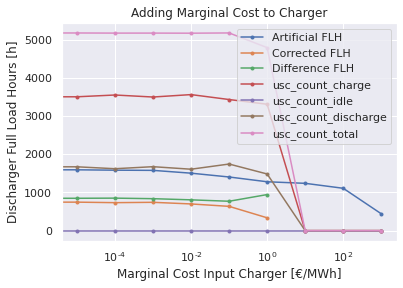

In [34]:
lines = FLH_h2_discharger.iloc[0:10,:].plot(style='.-')
plt.xscale("log")
plt.title("Adding Marginal Cost to Charger")
plt.xlabel("Marginal Cost Input Charger [€/MWh]")
plt.ylabel("Discharger Full Load Hours [h]") #(full usage/year)

In [ ]:
lines = FLH_h2_discharger.iloc[10:20,:].plot(style='.-')
plt.xscale("log")
plt.title("Adding Marginal Cost to Discharger")
plt.xlabel("Marginal Cost Input Discharger [€/MWh]")
plt.ylabel("Discharger Full Load Hours [h]") #(full usage/year)

In [ ]:
lines = FLH_h2_discharger.iloc[20:30,:].plot(style='.-')
plt.xscale("log")
plt.title("Adding Marginal Cost to H2-Tank")
plt.xlabel("Marginal Cost Input H2-Tank [€/MWh]")
plt.ylabel("Discharger Full Load Hours [h]") #(full usage/year)

In [ ]:
lines = FLH_h2_discharger.iloc[30:40,:].plot(style='.-')
plt.xscale("log")
plt.title("Adding Marginal Cost to VRE")
plt.xlabel("Marginal Cost Input VRE [€/MWh]")
plt.ylabel("Discharger Full Load Hours [h]") #(full usage/year)

In [ ]:
FLH_h2_discharger.iloc[0:10,:]
FLH_h2_discharger.iloc[10:20,:]
FLH_h2_discharger.iloc[20:30,:]
FLH_h2_discharger.iloc[30:40,:]

## Plot Total System Cost 

In [ ]:
##NOTES. 
#mc_discharger = n10-n19
#mc_ratio = n20-n29
#mc_vre = n30-n39

In [ ]:
color = ("#b8ea04", 
"#ea048a", 
'#08ad97', 
"#4adbc8", 
"#6895dd", 
"#74c6f2", 
"#235ebc", 
"#f9d002", 
"#70af1d")

#battery,
#hydrogen storage
#reservoir & co
#run of river
#offshore AC
#offshore DC
#onshore
#solar
#transmission

In [ ]:
costs.iloc[:,0:9].T.plot.bar(stacked=True, figsize=(10,10), color = color)
plt.legend(loc=(1.04,0))
plt.title("Adding Marginal Cost to Charger")
plt.xlabel("Marginal Cost Input Charger [€/MWh]")
plt.ylabel("Total System Costs [B€ p.a.]")


In [ ]:
costs.iloc[:,10:19].T.plot.bar(stacked=True, figsize=(10,10),color = color)
plt.legend(loc=(1.04,0))
plt.title("Adding Marginal Cost to Discharger")
plt.xlabel("Marginal Cost Input Discharger [€/MWh]")
plt.ylabel("Total System Costs [B€ p.a.]")

In [ ]:
costs.iloc[:,20:29].T.plot.bar(stacked=True, figsize=(10,10),color = color)
plt.legend(loc=(1.04,0))
plt.title("Adding Marginal Cost to H2-tank")
plt.xlabel("Marginal Cost Input to H2-tank [€/MWh]")
plt.ylabel("Total System Costs [B€ p.a.]")

In [ ]:
costs.iloc[:,30:39].T.plot.bar(stacked=True, figsize=(10,10),color = color)
plt.legend(loc=(1.04,0))
plt.title("Adding Marginal Cost to VRE")
plt.xlabel("Marginal Cost Input to VRE [€/MWh]")
plt.ylabel("Total System Costs [B€ p.a.]")

In [ ]:
###CHECK
values = list(ns.values())
keys = list(ns.keys())
objective =  []

for i in range(0, len(keys)):
    C = calculate_objective(values[i], keys[i])
    objective.append(C)

In [ ]:
objective

# FLH/capacity factor generator

In [ ]:
cd "/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_scripts"

In [ ]:
import sys, os
import yaml

with open("config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

In [ ]:
def aggregate_p(n):
    return pd.concat([
        n.generators_t.p.sum().groupby(n.generators.carrier).sum(),
        n.storage_units_t.p.sum().groupby(n.storage_units.carrier).sum(),
        n.stores_t.p.sum().groupby(n.stores.carrier).sum(),
        n.links.groupby("carrier").p_nom_opt.sum(),
        -n.loads_t.p.sum().groupby(n.loads.carrier).sum()
        ])

In [ ]:
#def aggregate_costs(n, flatten=False, opts=None, existing_only=False):
for key, n in ns.items():
    assign_carriers(n)
    
costs = pd.DataFrame({k: aggregate_p_curtailed(n)/(aggregate_p_nom(n)*8760) for k, n in ns.items()}).sort_index(axis=1)#.drop("load")
#colors = costs.index.map(config["plotting"]["tech_colors"])
#colors = (config["plotting"]["tech_colors"])
costs = costs.rename(index=config["plotting"]["nice_names"])

costs = costs #Conversion to billions
#costs[:]

In [ ]:
#costs
#Percentage of curtailment

In [ ]:
((
    costs.loc["Solar"]
    +costs.loc["Onshore Wind"]
    +costs.loc["Offshore Wind (AC)"]
    +costs.loc["Offshore Wind (DC)"]
    #+costs.loc["Run of River"]
    #costs.loc["hydro+PHS"]
    
)/5).plot(style='.-')

plt.title("Percentage of Curtailment")
plt.xlabel("Charger - Discharger - Storage tank - VRE")
plt.ylabel("Average VRE p_curtailed/p_nom")

In [ ]:
#def aggregate_costs(n, flatten=False, opts=None, existing_only=False):
for key, n in ns.items():
    assign_carriers(n)
    
costs = pd.DataFrame({k: aggregate_p(n)/(aggregate_p_nom(n)*8760) for k, n in ns.items()}).sort_index(axis=1)#.drop("load")
#colors = costs.index.map(config["plotting"]["tech_colors"])
#colors = (config["plotting"]["tech_colors"])
costs = costs.rename(index=config["plotting"]["nice_names"])

costs = costs #Conversion to billions
#costs[:]

In [ ]:
((
    costs.loc["Solar"]
    +costs.loc["Onshore Wind"]
    +costs.loc["Offshore Wind (AC)"]
    +costs.loc["Offshore Wind (DC)"]
    #+costs.loc["Run of River"]
    #costs.loc["hydro+PHS"]
    
)/5).plot(style='.-')

plt.title("Capacity Factor of VRE assets")
plt.xlabel("Charger - Discharger - Storage tank - VRE")
plt.ylabel("p/(p_nom*8760)")

In [ ]:
#def aggregate_costs(n, flatten=False, opts=None, existing_only=False):
for key, n in ns.items():
    assign_carriers(n)
    
costs = pd.DataFrame({k: aggregate_p(n)/(aggregate_p_nom(n)) for k, n in ns.items()}).sort_index(axis=1)#.drop("load")
#colors = costs.index.map(config["plotting"]["tech_colors"])
#colors = (config["plotting"]["tech_colors"])
costs = costs.rename(index=config["plotting"]["nice_names"])

costs = costs #Conversion to billions
#costs[:]

In [ ]:
costs
#FLH of generators

In [ ]:
((
    costs.loc["Solar"]
    +costs.loc["Onshore Wind"]
    +costs.loc["Offshore Wind (AC)"]
    +costs.loc["Offshore Wind (DC)"]
    #+costs.loc["Run of River"]
    #+costs.loc["hydro+PHS"]
    
)/5).plot(style='.-')

plt.title("VRE Full Load Hour")
plt.xlabel("Charger - Discharger - Storage tank - VRE")
plt.ylabel("Average p/pnom [h]")

In [ ]:
#def aggregate_costs(n, flatten=False, opts=None, existing_only=False):
for key, n in ns.items():
    assign_carriers(n)
    
costs = pd.DataFrame({k: aggregate_p_nom(n) for k, n in ns.items()}).sort_index(axis=1)#.drop("load")
#colors = costs.index.map(config["plotting"]["tech_colors"])
#colors = (config["plotting"]["tech_colors"])
costs = costs.rename(index=config["plotting"]["nice_names"])

costs = costs #Conversion to billions
#costs[:]

In [ ]:
#optimised capacity
costs.sum()

In [ ]:
((
    costs.loc["Solar"]
    +costs.loc["Onshore Wind"]
    +costs.loc["Offshore Wind (AC)"]
    +costs.loc["Offshore Wind (DC)"]
    #+costs.loc["Run of River"]
    #+costs.loc["hydro+PHS"]
    
)/5).plot(style='.-')

plt.title("Total Installed Power")
plt.xlabel("Charger - Discharger - Storage tank - VRE")
plt.ylabel("p_nom in [MW]")

In [ ]:
#def aggregate_costs(n, flatten=False, opts=None, existing_only=False):
for key, n in ns.items():
    assign_carriers(n)
    
costs = pd.DataFrame({k: aggregate_p(n) for k, n in ns.items()}).sort_index(axis=1)#.drop("load")
#colors = costs.index.map(config["plotting"]["tech_colors"])
#colors = (config["plotting"]["tech_colors"])
costs = costs.rename(index=config["plotting"]["nice_names"])

costs = costs #Conversion to billions
#costs[:]

In [ ]:
#power output
costs

In [ ]:
((
    costs.loc["Solar"]
    +costs.loc["Onshore Wind"]
    +costs.loc["Offshore Wind (AC)"]
    +costs.loc["Offshore Wind (DC)"]
    #+costs.loc["Run of River"]
    #+costs.loc["hydro+PHS"]
    
)/6).plot(style='.-')

plt.title("Aggregated power output")
plt.xlabel("Charger - Discharger - Storage tank - VRE")
plt.ylabel("p in [MW]")